# Training modules overview

In [ ]:
from fastai.basic_train import *
from fastai.gen_doc.nbdoc import *
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

The fastai library is structured training around a [`Learner`](/basic_train.html#Learner) object that binds together a pytorch model, some data with an optimizer and a loss function, which then will allow us to launch training.

[`basic_train`](/basic_train.html#basic_train) contains the definition of this [`Learner`](/basic_train.html#Learner) class along with the wrapper around pytorch optimizer that the library uses. It defines the basic training loop that is used each time you call the [`fit`](/basic_train.html#fit) function in fastai (or one of its variants). This training loop is kept to the minimum number of instructions, and most of its customization happens in [`Callback`](/callback.html#Callback) objects.

[`callback`](/callback.html#callback) contains the definition of those, as well as the [`CallbackHandler`](/callback.html#CallbackHandler) that is responsible for the communication between the training loop and the [`Callback`](/callback.html#Callback) functions. It maintains a state dictionary to be able to provide to each [`Callback`](/callback.html#Callback) all the informations of the training loop, easily allowing any tweaks you could think of.

In [`callbacks`](/callbacks.html#callbacks), each [`Callback`](/callback.html#Callback) is then implemented in separate modules. Some deal with scheduling the hyperparameters, like [`callbacks.one_cycle`](/callbacks.one_cycle.html#callbacks.one_cycle), [`callbacks.lr_finder`](/callbacks.lr_finder.html#callbacks.lr_finder) or [`callback.general_sched`](/callbacks.general_sched.html#callbacks.general_sched). Others allow special kind of trainings like [`callbacks.fp16`](/callbacks.fp16.html#callbacks.fp16) (mixed precision) or [`callbacks.rnn`](/callbacks.rnn.html#callbacks.rnn). The [`Recorder`](/basic_train.html#Recorder) or [`callbacks.hooks`](/callbacks.hooks.html#callbacks.hooks) are useful to save some internal data.

[`train`](/train.html#train) then implements those callbacks with useful helper functions. Lastly [`metrics`](/metrics.html#metrics) contains all the functions you might want to call to evaluate your results.

## Walk-through of key functionality

We'll do a quick overview of the key pieces of fastai's training modules. See the separate module docs for details on each. We'll use the classic MNIST dataset for the training documentation, cut down to just 3's and 7's. To minimize the boilerplate in our docs we've defined a funcion to grab the data from <code>URLs.MNIST_SAMPLE</code> which will automatically download and unzip if not already done function, then we put it in an [`ImageDataBunch`](/vision.data.html#ImageDataBunch).

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

### Basic training with [`Learner`](/basic_train.html#Learner)

We can create minimal simple CNNs using [`simple_cnn`](/layers.html#simple_cnn) (see [`models`](/vision.models.html#vision.models) for details on creating models):

In [ ]:
model = simple_cnn((3,16,16,2))

The most important object for training models is [`Learner`](/basic_train.html#Learner), which needs to know, at minimum, what data to train with and what model to train.

In [ ]:
learn = Learner(data, model)

That's enough to train a model, which is done using [`fit`](/basic_train.html#fit). If you have a CUDA-capable GPU it will be used automatically. You have to say how many epochs to train for.

In [ ]:
learn.fit(1)

Total time: 00:02
epoch  train_loss  valid_loss
1      0.141339    0.121598    (00:02)



### Viewing metrics

To see how our training is going, we can request that it reports various [`metrics`](/metrics.html#metrics) after each epoch. You can pass it to the constructor, or set it later. Note that metrics are always calculated on the validation set.

In [ ]:
learn.metrics=[accuracy]
learn.fit(1)

Total time: 00:02
epoch  train_loss  valid_loss  accuracy
1      0.109016    0.091778    0.969578  (00:02)



### Extending training with callbacks

You can use [`callback`](/callback.html#callback)s to modify training in almost any way you can imagine. For instance, we've provided a callback to implement Leslie Smith's 1cycle training method.

In [ ]:
cb = OneCycleScheduler(learn, lr_max=0.01)
learn.fit(1, callbacks=cb)

Total time: 00:02
epoch  train_loss  valid_loss  accuracy
1      0.091946    0.068201    0.974975  (00:02)



The [`Recorder`](/basic_train.html#Recorder) callback is automatically added for you, and you can use it to see what happened in your training, e.g.:

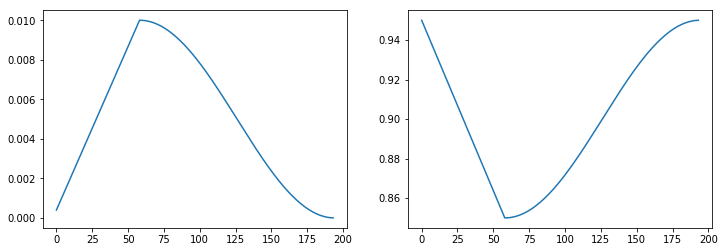

In [ ]:
learn.recorder.plot_lr(show_moms=True)

### Extending [`Learner`](/basic_train.html#Learner) with [`train`](/train.html#train)

Many of the callbacks can be used more easily by taking advantage of the [`Learner`](/basic_train.html#Learner) extensions in [`train`](/train.html#train). For instance, instead of creating OneCycleScheduler manually as above, you can simply call [`Learner.fit_one_cycle`](/train.html#fit_one_cycle):

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:02
epoch  train loss  valid loss  accuracy
0      0.044362    0.045060    0.984298  (00:02)



### Applications

Note that if you're training a model for one of our supported *applications*, there's a lot of help available to you in the application modules:

- [`vision`](/vision.html#vision)
- [`text`](/text.html#text)
- [`tabular`](/tabular.html#tabular)
- [`collab`](/collab.html#collab)

For instance, let's use [`create_cnn`](/vision.learner.html#create_cnn) (from [`vision`](/vision.html#vision)) to quickly fine-tune a pre-trained Imagenet model for MNIST (not a very practical approach, of course, since MNIST is handwriting and our model is pre-trained on photos!).

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(1)

Total time: 00:09
epoch  train loss  valid loss  accuracy
0      0.093473    0.068315    0.976938  (00:09)

